In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
df_sales = pd.read_csv('all_orders.csv')
df_sales.head()

,ORDER_ID,ORDER_ITEM_NR,COMBO,COMBO_ITEM_NR,COUNTRY,FISCAL_WEEK,PROD_ID,ORDER_QTY
0,357775,40,Y,20,New Zealand,201941,P000517,1
1,370120,20,Y,10,New Zealand,201941,P000254,2
2,382465,30,Y,20,New Zealand,201941,P000218,1
3,394810,60,Y,40,New Zealand,201940,P000518,1
4,407155,20,Y,10,New Zealand,201941,P000230,1


In [3]:
df_attribute= pd.read_csv('product_attribute.csv')
df_attribute.head()

,PROD_ID,PRODUCT_TYPE,PRODUCT_VERSION,MATERIAL_DESC,MATERIAL_COLOR,CONNECTIVITY
0,P000517,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN
1,P000254,BOTTLE,Version 2,STAINLESS STEEL,Ochre,BLUETOOTH
2,P000218,BOTTLE,Version 2,STAINLESS STEEL,Zinc,WIFI
3,P000518,CAP,NaN,POLISHED ALUMINIUM,Mahogany,NaN
4,P000230,BOTTLE,Version 2,POLISHED ALUMINIUM,Mustard,WIFI


In [8]:
merged_df = pd.merge(df_sales, df_attribute, on= 'PROD_ID', how='inner')

In [4]:
df_time= pd.read_csv('fiscal_calendar.csv')
df_time.columns

Index(['FISCAL_WEEK', 'FISCAL_YEAR', 'MONTH', 'WEEK_IN_QUARTER',
       'WEEK_IN_MONTH'],
      dtype='object')

In [7]:
def get_week_start_date(year, month, week_in_month):
    month_start = pd.Timestamp(year=year, month=month, day=1)
    # Convert to Python native int type
    week_offset = int(week_in_month) - 1
    week_start = month_start + timedelta(weeks=week_offset)
    return week_start

# Iterate over the DataFrame rows
week_start_dates = []
for index, row in df_time.iterrows():
    week_start_date = get_week_start_date(row['FISCAL_YEAR'], row['MONTH'], row['WEEK_IN_MONTH'])
    week_start_dates.append(week_start_date)

# Add the calculated dates as a new column
df_time['WEEK_START_DATE'] = week_start_dates

df_time.head()

,FISCAL_WEEK,FISCAL_YEAR,MONTH,WEEK_IN_QUARTER,WEEK_IN_MONTH,WEEK_START_DATE
0,201833,2018,8,7,2,2018-08-08
1,201902,2019,1,2,2,2019-01-08
2,202027,2020,6,13,4,2020-06-22
3,201803,2018,1,3,3,2018-01-15
4,201618,2016,4,5,5,2016-04-29


In [10]:
# df_old= pd.read_csv('Merged_df.csv')
df_merged = pd.merge(merged_df, df_time, on='FISCAL_WEEK', how='left')
df_merged.head()

,ORDER_ID,ORDER_ITEM_NR,COMBO,COMBO_ITEM_NR,COUNTRY,FISCAL_WEEK,PROD_ID,ORDER_QTY,PRODUCT_TYPE,PRODUCT_VERSION,MATERIAL_DESC,MATERIAL_COLOR,CONNECTIVITY,FISCAL_YEAR,MONTH,WEEK_IN_QUARTER,WEEK_IN_MONTH,WEEK_START_DATE
0,357775,40,Y,20,New Zealand,201941,P000517,1,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,10,2,2,2019-10-08
1,15863095,30,Y,10,New Zealand,201930,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,7,4,4,2019-07-22
2,17184010,30,Y,10,Macao,201948,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,11,9,4,2019-11-22
3,34911430,30,Y,10,New Zealand,201930,P000517,1,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,7,4,4,2019-07-22
4,34973155,30,Y,10,New Zealand,201931,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,7,5,5,2019-07-29


In [48]:
df_merged['COUNTRY'].value_counts()

COUNTRY
New Zealand    225009
Macao           77363
Name: count, dtype: int64

In [45]:
type_ts = df_merged.groupby(['PRODUCT_TYPE', 'WEEK_START_DATE']).sum()

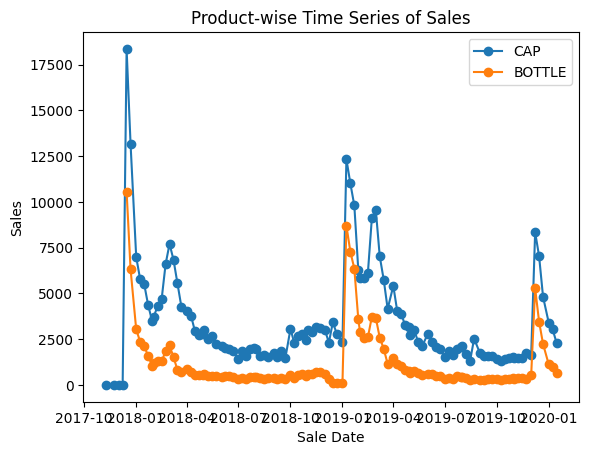

In [50]:
# Plotting time series data for each product
for product_id in df_merged['PRODUCT_TYPE'].unique():
    type_data = type_ts.xs(product_id, level='PRODUCT_TYPE')
    plt.plot(type_data.index, type_data['ORDER_QTY'], marker='o', label=product_id)

plt.xlabel('Sale Date')
plt.ylabel('Sales')
plt.title('Product-wise Time Series of Sales')
plt.legend()
plt.show()

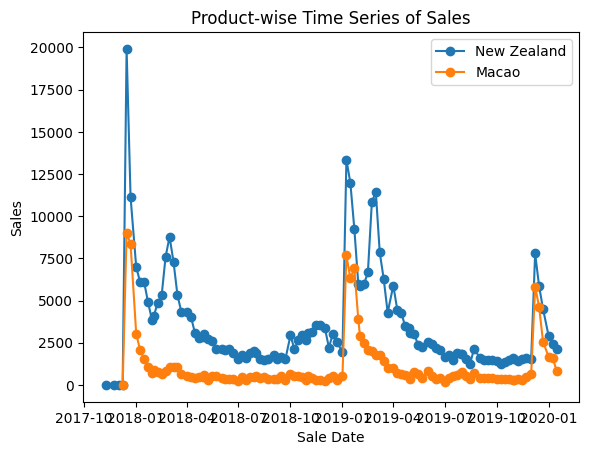

In [51]:
country_ts = df_merged.groupby(['COUNTRY', 'WEEK_START_DATE']).sum()

# Plotting time series data for each product
for product_id in df_merged['COUNTRY'].unique():
    country_data = country_ts.xs(product_id, level='COUNTRY')
    plt.plot(country_data.index, country_data['ORDER_QTY'], marker='o', label=product_id)

plt.xlabel('Sale Date')
plt.ylabel('Sales')
plt.title('Product-wise Time Series of Sales')
plt.legend()
plt.show()

In [63]:
order_qty_arrays = {}

for product_id in df_merged['COUNTRY'].unique():
    country_data = country_ts.xs(product_id, level='COUNTRY')
    order_qty_array = country_data['ORDER_QTY'].values  # Extracting as a NumPy array
    order_qty_arrays[product_id] = order_qty_array

order_qty_arrays.columns

AttributeError: 'dict' object has no attribute 'columns'

In [61]:
# Extract features with tsfresh
from tsfresh import extract_features


extracted_features = extract_features(order_qty_arrays, column_id='order_qty_arrays', column_sort='WEEK_START_DATE')

# Drop any NaNs generated by tsfresh
extracted_features = extracted_features.dropna(axis=1)

# Example target variable (replace with your target)
# Assuming the target is the 'value' column shifted by one time step
y = df.groupby('id')['value'].shift(-1).dropna()

# Aligning the extracted features with the target variable
# This step might vary based on your actual data structure
X = extracted_features.loc[y.index.levels[1]]

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [56]:
country_ts.head()

ORDER_ID  ORDER_ITEM_NR  \
COUNTRY WEEK_START_DATE                                 
Macao   2017-12-08          2199607180             10   
        2017-12-15       6192470691090         158960   
        2017-12-22       5836373196080         147300   
        2018-01-01       2106008501310          54420   
        2018-01-08       1446821746440          35940   

                                                                     COMBO  \
COUNTRY WEEK_START_DATE                                                      
Macao   2017-12-08                                                       N   
        2017-12-15       YYNYYYYNYYYYNYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY...   
        2017-12-22       YYYYYYYYYYYYYYYYYYYYYYYNYYYYYYYYYYYYYYYNYYYYYY...   
        2018-01-01       YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY...   
        2018-01-08       YYYNYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY...   

                         COMBO_ITEM_NR  FISCAL_WEEK  \
COUNTRY WEEK_START_DATE                               
Macao   2017-12-08                   0       201750   
        2017-12-15               66450   1180848603   
        2017-12-22               61440   1089864304   
        2018-01-01               23210    396538965   
        2018-01-08               14750    266378640   

                                                                   PROD_ID  \
COUNTRY WEEK_START_DATE                                                      
Macao   2017-12-08                                                 P000714   
        2017-12-15       P000906P000906P000906P000906P000906P000906P000...   
        2017-12-22       P000906P000906P000906P000906P000906P000906P000...   
        2018-01-01       P000906P000906P000906P000906P000906P000906P000...   
        2018-01-08       P000906P000906P000906P000906P000906P000906P000...   

                         ORDER_QTY  \
COUNTRY WEEK_START_DATE              
Macao   2017-12-08               3   
        2017-12-15            9008   
        2017-12-22            8355   
        2018-01-01            3033   
        2018-01-08            2047   

                                                              PRODUCT_TYPE  \
COUNTRY WEEK_START_DATE                                                      
Macao   2017-12-08                                                     CAP   
        2017-12-15       CAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPC...   
        2017-12-22       CAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPC...   
        2018-01-01       CAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPC...   
        2018-01-08       CAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPC...   

                                                           PRODUCT_VERSION  \
COUNTRY WEEK_START_DATE                                                      
Macao   2017-12-08                                                       0   
        2017-12-15       Version 1Version 1Version 1Version 1Version 1V...   
        2017-12-22       Version 1Version 1Version 1Version 1Version 1V...   
        2018-01-01       Version 1Version 1Version 1Version 1Version 1V...   
        2018-01-08       Version 1Version 1Version 1Version 1Version 1V...   

                                                             MATERIAL_DESC  \
COUNTRY WEEK_START_DATE                                                      
Macao   2017-12-08                                      POLISHED ALUMINIUM   
        2017-12-15       PLASTICPLASTICPLASTICPLASTICPLASTICPLASTICPLAS...   
        2017-12-22       PLASTICPLASTICPLASTICPLASTICPLASTICPLASTICPLAS...   
        2018-01-01       PLASTICPLASTICPLASTICPLASTICPLASTICPLASTICPLAS...   
        2018-01-08       PLASTICPLASTICPLASTICPLASTICPLASTICPLASTICPLAS...   

                                                            MATERIAL_COLOR  \
COUNTRY WEEK_START_DATE                                                      
Macao   2017-12-08                                                       0   
        

In [20]:
print('Final shape:', df_merged.shape)
df_merged.head()

Final shape: (302372, 18)


,ORDER_ID,ORDER_ITEM_NR,COMBO,COMBO_ITEM_NR,COUNTRY,FISCAL_WEEK,PROD_ID,ORDER_QTY,PRODUCT_TYPE,PRODUCT_VERSION,MATERIAL_DESC,MATERIAL_COLOR,CONNECTIVITY,FISCAL_YEAR,MONTH,WEEK_IN_QUARTER,WEEK_IN_MONTH,WEEK_START_DATE
0,357775,40,Y,20,New Zealand,201941,P000517,1,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,10,2,2,2019-10-08
1,15863095,30,Y,10,New Zealand,201930,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,7,4,4,2019-07-22
2,17184010,30,Y,10,Macao,201948,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,11,9,4,2019-11-22
3,34911430,30,Y,10,New Zealand,201930,P000517,1,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,7,4,4,2019-07-22
4,34973155,30,Y,10,New Zealand,201931,P000517,2,CAP,NaN,POLISHED ALUMINIUM,Harvest Gold,NaN,2019,7,5,5,2019-07-29


In [37]:
# Plotting time series data for each product
for product_id in df_merged['PROD_ID'].unique():
    product_data = product_sales_ts.xs(product_id, level='PROD_ID')
    plt.plot(product_data.index, product_data['ORDER_QTY'], marker='o', label=product_id)

plt.xlabel('Sale Date')
plt.ylabel('Sales')
plt.title('Product-wise Time Series of Sales')
plt.legend()
plt.show()

KeyError: 'Level PRODUCT_TYPE not found'

,ORDER_ID,ORDER_ITEM_NR,COMBO,COMBO_ITEM_NR,COUNTRY,FISCAL_WEEK,ORDER_QTY,PRODUCT_TYPE,PRODUCT_VERSION,MATERIAL_DESC,MATERIAL_COLOR,CONNECTIVITY,FISCAL_YEAR,MONTH,WEEK_IN_QUARTER,WEEK_IN_MONTH
WEEK_START_DATE,,,,,,,,,,,,,,,,
2018-12-08,39972880,20,N,0,Macao,201850,1,CAP,0,BRUSHED ALUMINUM,Purple,0,2018,12,11,2
2018-12-15,37004748770,690,YYYYYYYYNYNYNYYYNNNNNYYYYY,210,New ZealandNew ZealandNew ZealandNew ZealandMa...,5248126,39,CAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPC...,0,BRUSHED ALUMINUMBRUSHED ALUMINUMBRUSHED ALUMIN...,PurplePurplePurplePurplePurplePurplePurplePurp...,0,52468,312,312,78
2018-12-22,63763211335,950,YYYNNYYNYYYNNNYNYNNYYYYNNNYNYNNNYNNNNYYNYYN,250,New ZealandNew ZealandNew ZealandNew ZealandNe...,8679636,90,CAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPC...,0,BRUSHED ALUMINUMBRUSHED ALUMINUMBRUSHED ALUMIN...,PurplePurplePurplePurplePurplePurplePurplePurp...,0,86774,516,559,172
2019-01-01,48986334130,1110,YYNYNYYYYYNYNYYNNNNNYYYNNNYYYYNYYYYNN,330,New ZealandMacaoNew ZealandNew ZealandNew Zeal...,7470337,70,CAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPC...,0,BRUSHED ALUMINUMBRUSHED ALUMINUMBRUSHED ALUMIN...,PurplePurplePurplePurplePurplePurplePurplePurp...,0,74703,37,37,37
2019-01-08,513886097350,13270,YNNNYYYYYYYYYYYNYYYYYYYYNNNYYYYYYYYYYYYYYNNNYY...,4530,MacaoNew ZealandNew ZealandNew ZealandMacaoMac...,93480626,767,CAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPC...,0,BRUSHED ALUMINUMBRUSHED ALUMINUMBRUSHED ALUMIN...,PurplePurplePurplePurplePurplePurplePurplePurp...,0,934797,463,926,926
2019-01-15,460578921745,13740,NNNNNYYYYYYYYYYYYYYYYYYYNNYYYYYYYYYYYYYNYYYYYY...,4970,New ZealandNew ZealandNew ZealandNew ZealandNe...,90452544,754,CAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPC...,0,BRUSHED ALUMINUMBRUSHED ALUMINUMBRUSHED ALUMIN...,PurplePurplePurplePurplePurplePurplePurplePurp...,0,904512,448,1344,1344
2019-01-22,365747011950,10460,NNYYYYYYNNNYYYYYYYYYYNNNYYYYNYYYYYYYYYYNNNYYYY...,3740,New ZealandNew ZealandNew ZealandNew ZealandNe...,70868304,579,CAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPC...,0,BRUSHED ALUMINUMBRUSHED ALUMINUMBRUSHED ALUMIN...,PurplePurplePurplePurplePurplePurplePurplePurp...,0,708669,351,1404,1404
2019-01-29,218896665265,5910,YYYYYNNNYYYYYYNYYNNYYYYNYYYYYYYYNYYYNNYYYNNNYY...,2060,MacaoNew ZealandMacaoNew ZealandMacaoNew Zeala...,41996240,353,CAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPC...,0,BRUSHED ALUMINUMBRUSHED ALUMINUMBRUSHED ALUMIN...,PurplePurplePurplePurplePurplePurplePurplePurp...,0,419952,208,1040,1040
2019-02-01,180292856300,5180,YNNYYYYYYYYYYNNNNNYYYYYNYYYYNYYYYYYYYNNYYYNNNY...,1840,MacaoNew ZealandNew ZealandNew ZealandMacaoMac...,36746892,317,CAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPCAPC...,0,BRUSHED ALUMINUMBRUSHED ALUMINUMBRUSHED ALUMIN...,PurplePurplePurplePurplePurplePurplePurplePurp...,0,367458,364,1092,182
